In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import plot_model
from PIL import Image
import shutil

# Define the paths
data_dir = "/kaggle/input/indonesian-batik-motifs"
filtered_data_dir = os.path.join("/kaggle/working", "filtered")
os.makedirs(filtered_data_dir, exist_ok=True)

# Define desired classes
desired_classes = ['batik-sidoluhur', 'batik-tambal', 'batik-sogan']

# Filter and create symbolic links for the desired classes
for class_name in desired_classes:
    class_dir = os.path.join(data_dir, class_name)
    if os.path.exists(class_dir):  # Check if the class directory exists
        dest_dir = os.path.join(filtered_data_dir, class_name)
        if not os.path.exists(dest_dir):  # If symbolic link doesn't already exist
            os.symlink(class_dir, dest_dir)  # Create symbolic link


In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Constants
PATH = "/kaggle/working/filtered"
IMG_WIDTH = 300
IMG_HEIGHT = 300
RANDOM_STATE = 42
# Split ratios
TRAIN_SIZE = 0.8  # 80% train
VAL_SIZE = 0.1
TEST_SIZE = 0.1

def load_image_dataset(path, img_width, img_height):
    """
    Load images and classes from directory structure
    Returns images array, classes array, and labels dictionary
    """
    images = []
    classes = []
    labels = {}

    # Load images and create labels
    for i, class_dir in enumerate(os.listdir(path)):
        class_path = os.path.join(path, class_dir)

        # Skip if not a directory
        if not os.path.isdir(class_path):
            continue

        for filename in os.listdir(class_path):
            # Load and preprocess image
            image_path = os.path.join(path, class_dir, filename)
            try:
                image = load_img(
                    image_path,
                    target_size=(img_width, img_height),
                    color_mode='rgb'
                )
                image = img_to_array(image)
                image = image / 255.0  # Normalize

                images.append(image)
                classes.append(i)

            except Exception as e:
                print(f"Error loading {image_path}: {str(e)}")
                continue

        labels[i] = class_dir
        print(f'Loaded {class_dir} (class {i})')

    return np.array(images), np.array(classes), labels

# Load the dataset
images, classes, labels = load_image_dataset(PATH, IMG_WIDTH, IMG_HEIGHT)

# Print initial dataset information
print("\nDataset Summary:")
print(f"Total images: {len(images)}")
print(f"Image shape: {images[0].shape}")
print("Class distribution:")
for class_idx, class_name in labels.items():
    class_count = np.sum(classes == class_idx)
    print(f"{class_name}: {class_count} images")

# First split: train and temp (validation + test combined)
X_train, X_temp, y_train, y_temp = train_test_split(
    images,
    classes,
    train_size=TRAIN_SIZE,
    random_state=RANDOM_STATE,
    stratify=classes
)

# Second split: divide temp into validation and test
# Calculate relative validation size compared to temp set
val_ratio = VAL_SIZE / (VAL_SIZE + TEST_SIZE)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    train_size=val_ratio,
    random_state=RANDOM_STATE,
    stratify=y_temp
)

# One-hot encode targets
y_train = to_categorical(y_train, num_classes=len(labels))
y_val = to_categorical(y_val, num_classes=len(labels))
y_test = to_categorical(y_test, num_classes=len(labels))

# Print split information
print("\nSplit Summary:")
print(f"Training set: {X_train.shape[0]} images")
print(f"Validation set: {X_val.shape[0]} images")
print(f"Test set: {X_test.shape[0]} images")

# Verify class distribution in all splits
print("\nClass distribution in splits:")
for class_idx, class_name in labels.items():
    train_count = np.sum(np.argmax(y_train, axis=1) == class_idx)
    val_count = np.sum(np.argmax(y_val, axis=1) == class_idx)
    test_count = np.sum(np.argmax(y_test, axis=1) == class_idx)

    print(f"\n{class_name}:")
    print(f"  Train: {train_count} images ({train_count/len(y_train)*100:.1f}%)")
    print(f"  Validation: {val_count} images ({val_count/len(y_val)*100:.1f}%)")
    print(f"  Test: {test_count} images ({test_count/len(y_test)*100:.1f}%)")


Loaded batik-sidoluhur (class 0)
Loaded batik-sogan (class 1)
Loaded batik-tambal (class 2)

Dataset Summary:
Total images: 150
Image shape: (300, 300, 3)
Class distribution:
batik-sidoluhur: 50 images
batik-sogan: 50 images
batik-tambal: 50 images

Split Summary:
Training set: 120 images
Validation set: 15 images
Test set: 15 images

Class distribution in splits:

batik-sidoluhur:
  Train: 40 images (33.3%)
  Validation: 5 images (33.3%)
  Test: 5 images (33.3%)

batik-sogan:
  Train: 40 images (33.3%)
  Validation: 5 images (33.3%)
  Test: 5 images (33.3%)

batik-tambal:
  Train: 40 images (33.3%)
  Validation: 5 images (33.3%)
  Test: 5 images (33.3%)


Examples of augmented batik images:


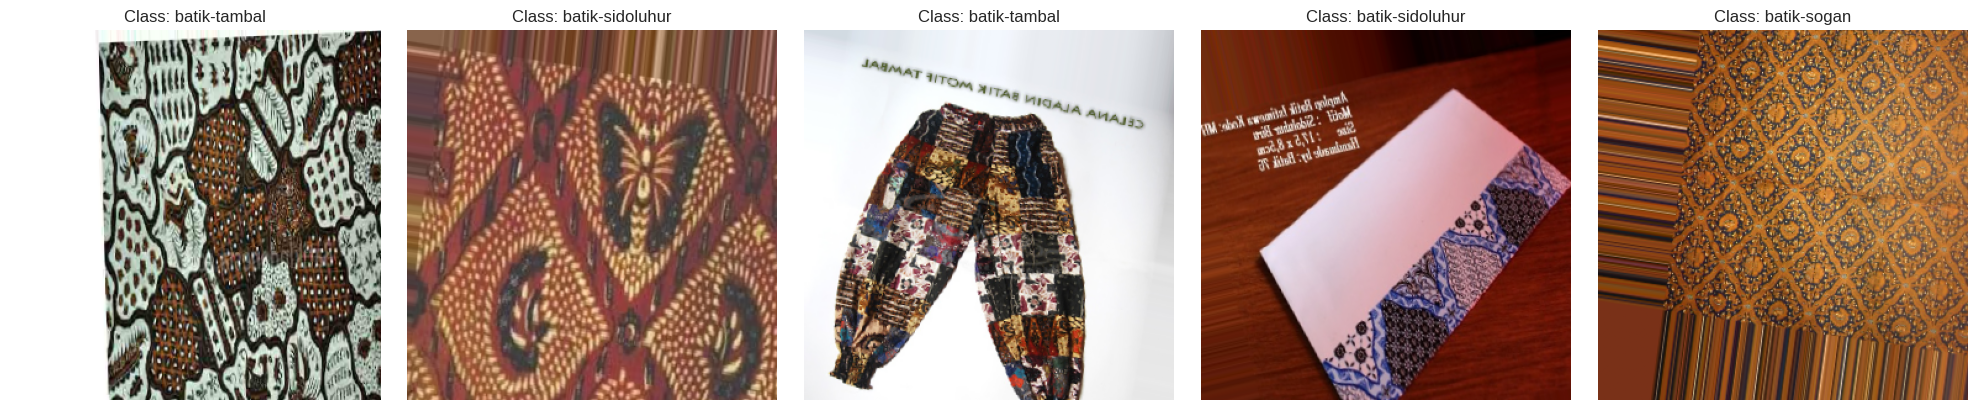

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

def create_batik_data_generators(X_train, y_train, X_val, y_val, X_test, y_test, batch_size=32):
    """
    Create optimized data generators for batik classification
    Parameters specifically tuned for batik pattern characteristics
    """

    # Training data generator with augmentation
    train_datagen = ImageDataGenerator(
        # Geometric transformations
        rotation_range=20,          # Moderate rotation to preserve pattern integrity
        width_shift_range=0.2,     # Horizontal shift
        height_shift_range=0.2,    # Vertical shift
        shear_range=0.2,           # Slight shear for pattern variation
        zoom_range=0.2,           # Zoom for scale invariance
        horizontal_flip = True,
        vertical_flip=False,
        fill_mode ='nearest'
    )

    # Validation data generator (no augmentation)
    val_datagen = ImageDataGenerator()

    # Test data generator (no augmentation)
    test_datagen = ImageDataGenerator()

    # Create generators
    train_generator = train_datagen.flow(
        X_train,
        y_train,
        batch_size=batch_size,
        shuffle=True
    )

    validation_generator = val_datagen.flow(
        X_val,
        y_val,
        batch_size=batch_size,
        shuffle=False
    )

    test_generator = test_datagen.flow(
        X_test,
        y_test,
        batch_size=batch_size,
        shuffle=False
    )

    return train_generator, validation_generator, test_generator

def visualize_batik_augmentation(generator, labels_dict, num_samples=5):
    """
    Visualize augmented batik images with their labels
    """
    plt.figure(figsize=(20, 4))

    # Get a batch of augmented images
    images, labels = next(generator)

    for i in range(min(num_samples, len(images))):
        plt.subplot(1, num_samples, i + 1)

        # Display the image
        plt.imshow(images[i])

        # Get the class name
        class_idx = np.argmax(labels[i])
        class_name = labels_dict[class_idx]

        plt.title(f'Class: {class_name}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Create the generators
train_gen, val_gen, test_gen = create_batik_data_generators(
    X_train, y_train,
    X_val, y_val,
    X_test, y_test
)

# Visualize augmented examples
print("Examples of augmented batik images:")
visualize_batik_augmentation(train_gen, labels)

In [ ]:
#Scratch Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D,GlobalAveragePooling2D
model = Sequential([
    Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3)),

    Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),


    Dropout(0.2),
    Flatten(),

    Dense(units=256, activation='relu'),
    Dropout(0.3),
    Dense(units=len(labels), activation='softmax')
])

In [ ]:
# try implement batchnorm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Dense, Flatten,
                                   Dropout, BatchNormalization, LeakyReLU)

model2 = Sequential([
    # Input Layer
    Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3)),

    # First Convolutional Block
    Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
    BatchNormalization(),

    MaxPooling2D(pool_size=(2, 2)),

    # Second Convolutional Block
    Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
    BatchNormalization(),

    MaxPooling2D(pool_size=(2, 2)),

    # Third Convolutional Block
    Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),

    MaxPooling2D(pool_size=(2, 2)),

    # Fourth Convolutional Block
    Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
    BatchNormalization(),

    MaxPooling2D(pool_size=(2, 2)),

    # Classifier
    Dropout(0.2),
    Flatten(),

    Dense(units=256, activation='relu'),
    Dropout(0.3),
    Dense(units=len(labels), activation='softmax')
])

In [ ]:
EPOCHS=30
LEARNING_RATE=0.0001
BATCH_SIZE=32

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

In [ ]:
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_80 (Conv2D)                   │ (None, 300, 300, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_80 (MaxPooling2D)      │ (None, 150, 150, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_81 (Conv2D)                   │ (None, 150, 150, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_81 (MaxPooling2D)      │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_82 (Conv2D)                   │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_82 (MaxPooling2D)      │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_83 (Conv2D)                   │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_83 (MaxPooling2D)      │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_40 (Dropout)                 │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_30 (Flatten)                 │ (None, 82944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 256)                 │      21,233,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_41 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,623,107 (82.49 MB)

 Trainable params: 21,623,107 (82.49 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model2.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.3081 - loss: 1.1223 - val_accuracy: 0.3333 - val_loss: 1.1305 - learning_rate: 1.0000e-04
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.3201 - loss: 1.1142 - val_accuracy: 0.4000 - val_loss: 1.0830 - learning_rate: 1.0000e-04
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.3433 - loss: 1.0972 - val_accuracy: 0.4000 - val_loss: 1.0770 - learning_rate: 1.0000e-04
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.3485 - loss: 1.0996 - val_accuracy: 0.4667 - val_loss: 1.0647 - learning_rate: 1.0000e-04
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.3959 - loss: 1.0729 - val_accuracy: 0.6000 - val_loss: 1.0573 - learning_rate: 1.0000e-04
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.4203 - loss: 1.0715 - val_accuracy: 0.4667 - val_loss: 1.0401 - learning_rate: 1.0000e-04
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.5224 - loss: 1.0532 - val

In [ ]:
loss, accuracy = model.evaluate(test_gen)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6667 - loss: 0.7495
Test Loss: 0.7495376467704773
Test Accuracy: 0.6666666865348816


In [ ]:
# Train the model
history2 = model2.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.3323 - loss: 3.3670 - val_accuracy: 0.3333 - val_loss: 1.1053 - learning_rate: 1.0000e-04
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.4606 - loss: 2.4968 - val_accuracy: 0.3333 - val_loss: 1.1026 - learning_rate: 1.0000e-04
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.4798 - loss: 2.3071 - val_accuracy: 0.3333 - val_loss: 1.1389 - learning_rate: 1.0000e-04
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.5880 - loss: 1.7617 - val_accuracy: 0.3333 - val_loss: 1.1730 - learning_rate: 1.0000e-04
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.5393 - loss: 1.5824 - val_accuracy: 0.3333 - val_loss: 1.1618 - learning_rate: 1.0000e-04


In [ ]:
loss, accuracy = model2.evaluate(test_gen)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3333 - loss: 1.1047
Test Loss: 1.1047437191009521
Test Accuracy: 0.3333333432674408


In [ ]:
from keras.applications import DenseNet121
from tensorflow.keras.models import Model

In [ ]:
#PreTrained Model
efNet = DenseNet121(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), weights='imagenet', include_top=False)

for layer in efNet.layers:
  layer.trainable = False

x = Flatten()(efNet.output)
prediction = Dense(3, activation='softmax')(x)
pt_model = Model(inputs=efNet.input, outputs=prediction)
pt_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])
pt_model.summary()

Model: "functional_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_32            │ (None, 300, 300, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_20         │ (None, 306, 306, 3)    │              0 │ input_layer_32[0][0]   │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 150, 150, 64)   │          9,408 │ zero_padding2d_20[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 150, 150, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 150, 150, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_21         │ (None, 152, 152, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 75, 75, 64)     │              0 │ zero_padding2d_21[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 75, 75, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 75, 75, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 75, 75, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 75, 75, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 75, 75, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 75, 75, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 75, 75, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,286,339 (27.80 MB)

 Trainable params: 248,835 (972.01 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
pt_history = pt_model.fit(train_gen, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=val_gen,callbacks=[early_stop, reduce_lr])

Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - accuracy: 0.3648 - loss: 1.5943 - val_accuracy: 0.6667 - val_loss: 0.9932 - learning_rate: 1.0000e-04
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - accuracy: 0.4255 - loss: 1.2006 - val_accuracy: 0.6667 - val_loss: 0.7957 - learning_rate: 1.0000e-04
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 0.5682 - loss: 1.2565 - val_accuracy: 0.7333 - val_loss: 0.7464 - learning_rate: 1.0000e-04
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.6554 - loss: 0.8132 - val_accuracy: 0.8000 - val_loss: 0.5382 - learning_rate: 1.0000e-04
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.7588 - loss: 0.7258 - val_accuracy: 0.8000 - val_loss: 0.4818 - learning_rate: 1.0000e-04
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.7611 - loss: 0.5453 - val_accuracy: 0.8000 - val_loss: 0.5096 - learning_rate: 1.0000e-04
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.7723 - loss: 0.

In [ ]:
pt_loss, pt_accuracy = pt_model.evaluate(test_gen)
print(f'Test Loss: {pt_loss}')
print(f'Test Accuracy: {pt_accuracy}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8000 - loss: 0.4309
Test Loss: 0.430902898311615
Test Accuracy: 0.800000011920929


<ipython-input-224-23c0b5ef9129>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


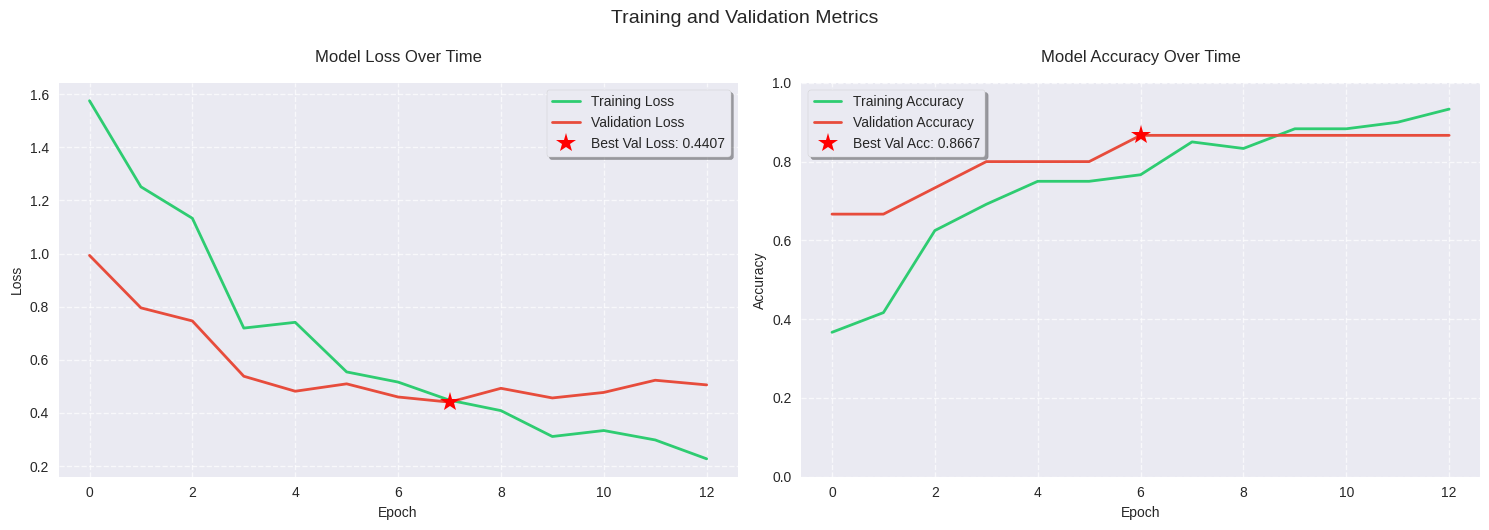


Best Validation Loss: 0.4407 (Epoch 8)
Best Validation Accuracy: 0.8667 (Epoch 7)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_training_history(history, figsize=(15, 5)):
    """
    Plot training history
    """
    # Set the style
    plt.style.use('seaborn')

    # Create figure and axis objects
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    # Plot Loss
    ax1.plot(history.history['loss'], label='Training Loss',
             color='#2ecc71', linewidth=2)
    ax1.plot(history.history['val_loss'], label='Validation Loss',
             color='#e74c3c', linewidth=2)

    # Loss plot styling
    ax1.set_title('Model Loss Over Time', fontsize=12, pad=15)
    ax1.set_xlabel('Epoch', fontsize=10)
    ax1.set_ylabel('Loss', fontsize=10)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend(frameon=True, fancybox=True, shadow=True)

    # Plot Accuracy
    ax2.plot(history.history['accuracy'], label='Training Accuracy',
             color='#2ecc71', linewidth=2)
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy',
             color='#e74c3c', linewidth=2)

    # Accuracy plot styling
    ax2.set_title('Model Accuracy Over Time', fontsize=12, pad=15)
    ax2.set_xlabel('Epoch', fontsize=10)
    ax2.set_ylabel('Accuracy', fontsize=10)
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend(frameon=True, fancybox=True, shadow=True)

    # Set y-axis for accuracy between 0 and 1
    ax2.set_ylim([0, 1])

    # Add points for best performance
    best_val_loss_epoch = np.argmin(history.history['val_loss'])
    best_val_acc_epoch = np.argmax(history.history['val_accuracy'])

    ax1.plot(best_val_loss_epoch, history.history['val_loss'][best_val_loss_epoch],
             'r*', markersize=15, label=f'Best Val Loss: {history.history["val_loss"][best_val_loss_epoch]:.4f}')
    ax2.plot(best_val_acc_epoch, history.history['val_accuracy'][best_val_acc_epoch],
             'r*', markersize=15, label=f'Best Val Acc: {history.history["val_accuracy"][best_val_acc_epoch]:.4f}')


    ax1.legend(frameon=True, fancybox=True, shadow=True)
    ax2.legend(frameon=True, fancybox=True, shadow=True)


    plt.tight_layout()


    fig.suptitle('Training and Validation Metrics', fontsize=14, y=1.05)

    # Show plot
    plt.show()

    # Print best metrics
    print(f"\nBest Validation Loss: {min(history.history['val_loss']):.4f} (Epoch {best_val_loss_epoch + 1})")
    print(f"Best Validation Accuracy: {max(history.history['val_accuracy']):.4f} (Epoch {best_val_acc_epoch + 1})")

# Use the function
plot_training_history(pt_history)


<ipython-input-224-23c0b5ef9129>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


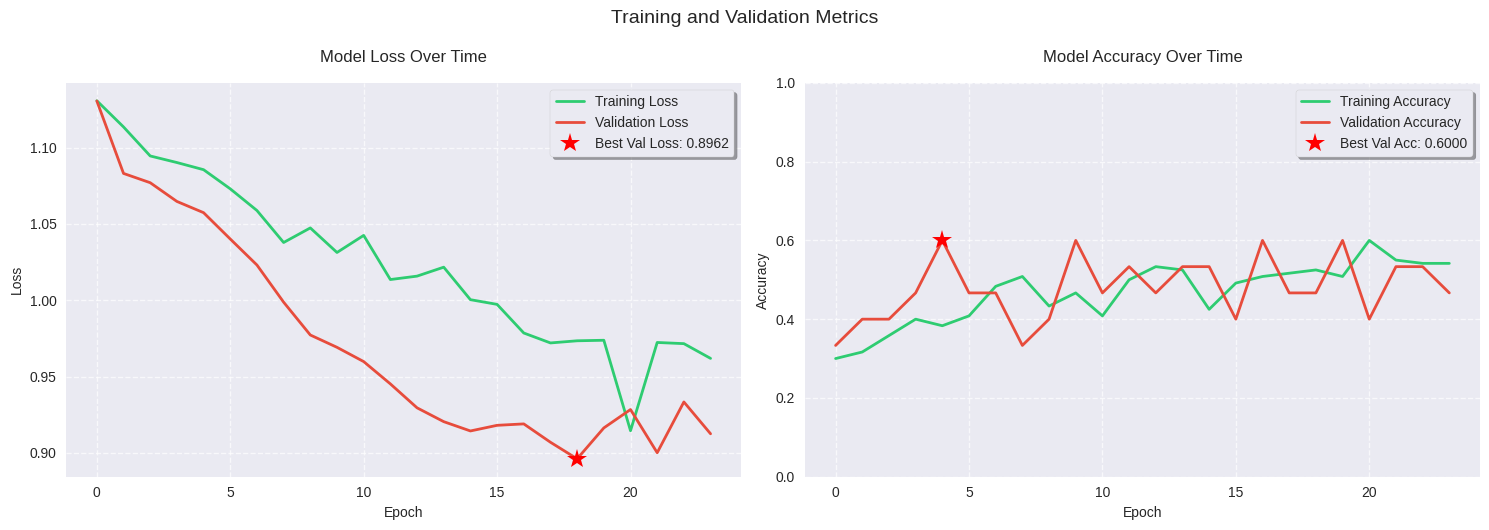


Best Validation Loss: 0.8962 (Epoch 19)
Best Validation Accuracy: 0.6000 (Epoch 5)


In [ ]:
plot_training_history(history)